# Clasificación Multi-Etiqueta de Posts de StackOverflow

Este proyecto tiene como objetivo predecir etiquetas de posts de StackOverflow utilizando técnicas de clasificación multi-etiqueta.

Este proyecto tiene como objetivo predecir etiquetas de *posts* de [StackOverflow](https://stackoverflow.com). Técnicamente, es una tarea de clasificación multi-etiqueta. Nótese que el lenguaje en el que están escritas las entradas es el **INGLÉS**, con lo que algunos de los pasos son específicos para dicho idioma.

## Librerías

Haremos uso de las siguientes librerías
- [Numpy](http://www.numpy.org) 
- [Pandas](https://pandas.pydata.org) 
- [scikit-learn](http://scikit-learn.org/stable/index.html)
- [NLTK](http://www.nltk.org) — librería básica para trabajar con texto en Python

aunque si quieres pudes usar spaCy para algunas tareas.

##  Preprocesado

Una de las primeras técnicas que vamos a utilizar para preprocesar textos es la eliminación de las conocidas como **stop words**, es decir, palabras que no aportan mucho significado, pero que son necesarias para que el texto sea legible y siga las normas. Para ello, lo primero es conseguir una lista con las *stop words* del lenguaje requerido.

Una opción para conseguir esta lista de palabras, es usar la librería `nltk`.

In [1]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/odremanferrer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


En este análisis trabajamos con un dataset de títulos de entradas de StackOverflow, debidamente etiquetado (con 100 etiquetas distintas).

In [2]:
from ast import literal_eval
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

In [4]:
train = read_data('data/train.tsv')
train, validation = train_test_split(train, test_size = .15, random_state = 0)
test = read_data('data/test.tsv')

In [5]:
train.head()

,title,tags
96598,How to create an array of leaf nodes of an htm...,"[javascript, arrays, dom]"
10007,how to make maven use test resources,"[java, maven]"
15802,How do I get the path where the user installed...,[java]
9114,why are my buttons not showing up?,"[java, swing]"
34247,How to loop an array with strings as indexes i...,"[php, arrays, string, loops]"


Como vemos, la columna *title* contiene los títulos de las entradas, y la columna *tags* una lista con las etiquetas de cada entrada, que puede ser un número arbitrario.

Para seguir los convenios, inicializamos `X_train`, `X_val`, `X_test`, `y_train`, `y_val`, `y_test`.

In [6]:
X_train_raw, y_train = train['title'].values, train['tags'].values
X_val_raw, y_val = validation['title'].values, validation['tags'].values
X_test_raw, y_test = test['title'].values, test['tags'].values

La principal dificultad de trabajar con lenguaje natural es que no está estructurado. Si cojemos el texto y creamos tokens simplemente separando por los espacios, tendremos *tokens* como '3.5?', 'do.', etc. Para evitar esos problemas, es útil preprocesar el texto.

### **Tarea 1 (Preprocesado):**

Implementa la función `text_tokenizer()` y `text_prepare()` siguiendo las instrucciones.

In [7]:
from string import ascii_lowercase


def text_tokenizer(text: str) -> list[str]:
    """
    Transforma un texto (str) en una lista de palabras/tokens (list).
    Es importante usar esta función siempre para ser consistentes.
    """
    # Dividimos el texto por espacios y eliminamos tokens vacíos
    return [token for token in text.split() if token]


# cargamos estas variables fuera de la función
# ya que la creación del set de stopwords es costoso y no queremos
# que se repita cada vez que se llame a la función
REPLACE_BY_SPACE = "[/(){}\\[\\]\\|@,;]"
GOOD_CHARS = ascii_lowercase + "".join([str(n) for n in range(10)]) + " #+_"
STOPWORDS = set(stopwords.words("english"))


def text_prepare(text: str) -> str:
    """
    Preprocesa el texto inicial:
    1. eliminando espacios al inicio y final, y convirtiéndolo a minúsculas
    2. cambia los caracteres de REPLACE_BY_SPACE por espacios
    3. elimina los caracteres que no estén en GOOD_CHARS
    4. elimina los tokens que sean STOPWORDS

    text: str
    return: str
    """
    # 1. Eliminar espacios y convertir a minúsculas
    text = text.strip().lower()
    
    # 2. Reemplazar caracteres especiales por espacios
    import re
    text = re.sub(REPLACE_BY_SPACE, " ", text)
    
    # 3. Eliminar caracteres que no estén en GOOD_CHARS
    text = "".join(char for char in text if char in GOOD_CHARS)
    
    # 4. Eliminar stopwords
    tokens = text_tokenizer(text)
    tokens = [token for token in tokens if token not in STOPWORDS]
    
    # Unir los tokens resultantes
    return " ".join(tokens)

In [8]:
def test_text_prepare():
    examples = ["   SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c++ memory vector<int> * arr?"]
    answers = ["sql server equivalent excels choose function", 
               "free c++ memory vectorint arr"]
    for ex, ans in zip(examples, answers):
        if text_prepare(ex) != ans:
            return "Respuesta incorrecta para: '%s'" % text_prepare(ex)
    return '¡Tests correctos!'

print(test_text_prepare())

¡Tests correctos!


Ahora preprocesamos los textos de todos los conjuntos:

In [9]:
X_train = [text_prepare(x) for x in X_train_raw]
X_val = [text_prepare(x) for x in X_val_raw]
X_test = [text_prepare(x) for x in X_test_raw]

In [10]:
X_train[:30]

['create array leaf nodes html dom using javascript',
 'make maven use test resources',
 'get path user installed java application',
 'buttons showing',
 'loop array strings indexes php',
 'resharper remove possible systemnullreferenceexception warning',
 'ajax combining ajaxsetup default settings',
 'getting gdb pretty printing c++ stl containers work eclipse',
 'cancel form submission button clicked',
 'retrieving socket objects iosocket',
 'update query codeigniter model working',
 'access database error information using rails postgres',
 'secure cookies set aspnet web application',
 'cross domain ajax request return html jsonp',
 'c# enums interfaces',
 'java 6 excessive memory usage',
 'select ok implement single socket read write timeout',
 'crossdomain preflight options forbidden',
 'zipping huge folder using zipfilesystem results outofmemoryerror',
 'select uitableview row programmatically',
 'allowed narrow scope method overriding',
 'filter excel table',
 'php css selector l

### **Tarea 2 (Cuentas de palabras y etiquetas):** 

Cuénta cuantas veces aparece cada token (palabra) y cada etiqueta en el corpus de entrenamiento. Es decir, crea un diccionario con las cuentas totales de palabras y etiquetas.
 
El resultado deben ser dos diccionarios *tags_counts* y *words_counts* del tipo `{'palabra_o_etiqueta': cuentas}`.

In [11]:
######################################
##ESCRIBE AQUÍ TU CÓDIGO
######################################

from collections import Counter

# Diccionario con todas las etiquetas del corpus de entrenamiento con sus cuentas
# Aplanamos la lista de listas de etiquetas y contamos cada etiqueta
tags_counts = Counter([tag for tags in y_train for tag in tags])

# Diccionario con todas las palabras del corpus de entrenamiento con sus cuentas
# Primero tokenizamos cada texto y luego contamos cada palabra
words_counts = Counter([word for text in X_train for word in text_tokenizer(text)])

##

Exploramos las más comunes:

In [12]:
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]
print(most_common_tags)
print(most_common_words)

[('c#', 16259), ('javascript', 16219), ('java', 15835)]
[('using', 7000), ('php', 4774), ('java', 4683)]


### Transformando el texto a vectores

Vamos a construir los vectores asociados a cada frase en dos representaciones distintas.


#### Bag of words

Recuerda que para crear la representación de *bag of words*, convertimos cada frase en un vector que cuenta el número de ocurrencias de cada token. Se siguien los pasos:
1. Encuentra los **N** tokens mas comunes del corpus de entrenamiento y se les asigna un índice, este es nuestro **vocabulario**. Creamos un diccionario para convertir de tokens a índices y viceversa.
2. Para cada frase en el corpus, creamos un vector de dimensión **N** y lo inicializamos con ceros.
3. Iteramos sobre los tokens de cada frase, y si el token está en el diccionario, incrementamos en 1 el índice correspondiente del vector.
   
**Tarea 3 (BagOfWords):** 

Contruye la función que transforma un texto en su representación *bag of words*.

Implementa la codificación de *bag of words* en la función `my_bag_of_words()` con un tamaño de diccionario de **N=5000**. Para definir el diccionario, sólo podemos usar el conjunto de entrenamiento, sino tendríamos un *data leaking*.

Primero, contruimos el vocabulario y los diccionarios correspondientes, así como un `set` con las palabras del diccionario.

In [13]:
DICT_SIZE = 5000

# Creamos el diccionario de índices a palabras tomando las DICT_SIZE palabras más frecuentes
INDEX_TO_WORDS = dict(enumerate(word for word, _ in words_counts.most_common(DICT_SIZE)))

# Creamos el diccionario inverso de palabras a índices
WORDS_TO_INDEX = {word: idx for idx, word in INDEX_TO_WORDS.items()}

ALL_WORDS = WORDS_TO_INDEX.keys()
assert len(ALL_WORDS)==DICT_SIZE

In [14]:
def my_bag_of_words(text: str, words_to_index: dict[str, int]) -> np.array:
    """
    text: str
    words_to_index: dict, diccionario con los índices del vocabulario

    return
    result_vector: numpy.array, vector con la representación bag-of-words de `text`
    """
    dict_size = len(words_to_index)
    result_vector = np.zeros(dict_size)

    # Para cada palabra en el texto
    for word in text_tokenizer(text):
        # Si la palabra está en nuestro vocabulario
        if word in words_to_index:
            # Incrementamos el contador en el índice correspondiente
            result_vector[words_to_index[word]] += 1

    return result_vector

In [15]:
def test_my_bag_of_words():
    words_to_index = {"hi": 0, "you": 1, "me": 2, "are": 3}
    examples = ["hi how are you", "hi hi hi you house"]
    answers = [[1, 1, 0, 1], [3, 1, 0, 0]]
    for ex, expected in zip(examples, answers):
        output = my_bag_of_words(ex, words_to_index)
        if (output != np.asarray(expected)).any():
            return f"Respuesta incorrecta: BOW('{ex}') = {output} != {expected}"
    return "¡Tests correctos!"


print(test_my_bag_of_words())

¡Tests correctos!


Ahora aplicamos la función anterior a todos los datos.

La representación *bag of words* devuelve vectores __*sparse*__ (la mayoría de sus entradas son ceros), con lo que conviene usar estructuras de datos especiales para datos *sparse* para ser eficientes.

Hay muchos [tipos de representación sparse](https://docs.scipy.org/doc/scipy/reference/sparse.html), y `sklearn` sólo trabaja con la representación [csr matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix), que es la que usamos.

In [16]:
from scipy import sparse as sp_sparse

In [17]:
X_train_mybag = sp_sparse.vstack(
    [sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX)) for text in X_train]
)
X_val_mybag = sp_sparse.vstack(
    [sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX)) for text in X_val]
)
X_test_mybag = sp_sparse.vstack(
    [sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX)) for text in X_test]
)
print("X_train shape ", X_train_mybag.shape)
print("X_val shape ", X_val_mybag.shape)
print("X_test shape ", X_test_mybag.shape)

X_train shape  (85000, 5000)
X_val shape  (15000, 5000)
X_test shape  (30000, 5000)


#### tf-idf

En vez de hacerlo desde cero, podemos usar la clase [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) de `sklearn`. Como siempre, para entrenar el codificador sólo se puede usar el set de entrenamiento.

Investiga los argumentos que definen `TfidfVectorizer`. Puedes filtrar las palabras muy raras y también las demasiado frecuentes. También permite utilizar combinaciones de palabras como tokens, es decir, n-gramas. Por último, el tokenizador por defecto separa palabras como 'c++' o 'c#' en varios tokens, pero esto no nos interesa, con lo que vamos a indicar que sólo separe por espacios con el parámetro `token_pattern`.

Puedes usar:
* `min_df=5`
* `max_df=0.9`
* `ngram_range=(1,2)` 
* `token_pattern='(\S+)'`

**Tarea 4 (tf-idf):** 

Contruye la función `tfidf_features()` que transforma el corpus en su representación *tf-idf*.

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy

# shorthand para el tipado de la CRS sparse matrix
sp_matrix = scipy.sparse.csr.csr_matrix


def tfidf_features(
    X_train: list[str], X_val: list[str], X_test: list[str]
) -> tuple[sp_matrix, sp_matrix, sp_matrix, dict]:
    """
    X_train, X_val, X_test — lista de str
    return representación TF-IDF de train, val y test, y el vocabulario word: idx
    """
    # Crea el TF-IDF vectorizer con los parámetros adecuados
    tfidf_vectorizer = TfidfVectorizer(
        min_df=5,  # Ignora términos que aparecen en menos de 5 documentos
        max_df=0.9,  # Ignora términos que aparecen en más del 90% de los documentos
        ngram_range=(1, 2),  # Incluye unigramas y bigramas
        token_pattern='(\\S+)'  # Patrón que considera cualquier secuencia de no-espacios como token
    )

    # Ajusta tfidf_vectorizer al set de entrenamiento y lo transforma
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    
    # Transforma los sets de validación y test usando el vocabulario aprendido
    X_val_tfidf = tfidf_vectorizer.transform(X_val)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)

    return X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vectorizer.vocabulary_

/var/folders/0j/c164mtv91wq70n6m8ptmtmww0000gn/T/ipykernel_54592/4177008494.py:5: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  sp_matrix = scipy.sparse.csr.csr_matrix


In [19]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [20]:
assert 'c++' in tfidf_vocab.keys()
assert 'c#' in tfidf_vocab.keys()

## Clasificador multi-etiqueta con sklearn

El resultado de nuestro clasificador puede consistir en varias etiquetas. Lo primero que tenemos que hacer, es convertir los `y` en números, al igual que hicimos con las X.

Se puede representar la multi-etiqueta convirtiendo cada lista de clases en un vector de 0's y 1's indicando la presencia de cada una de ellas.

Esto se puede hacer automáticamente con [MultiLabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) de `sklearn`.

In [21]:
from sklearn.preprocessing import MultiLabelBinarizer

In [22]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.transform(y_val)
y_test = mlb.transform(y_test)

In [23]:
print(y_train[0:5])

[[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 1 0 

### **Tarea 5 (Entrenamiento):** 

Implementa la función `train_classifier()` que entrena un clasificador dados los datos de entrenamiento. 

Como ya sabes, una clasificación multi-clase con $L$ etiquetas, se puede estudiar como $L$ clasificadores binarios. Esto se puede hacer en el formato *Uno contra todos*, que está implementado en [MultiOutputClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html).

Como clasificador base se puede usar [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Es uno de los métodos más simples, pero generalmente funciona bien en tareas de clasificación de texto.

Otra opción, que acepta directamente etiquetas Multi-label, es [RidgeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html).

Puedes encontrar más información en [Multiclass and multioutput algorithms](https://scikit-learn.org/stable/modules/multiclass.html). Por ejemplo, hay otra forma de combinar algoritmos de classificación en uno MultiOutput con [ClassifierChain](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.ClassifierChain.html#sklearn.multioutput.ClassifierChain).


In [24]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [25]:
from scipy.sparse import csr_matrix

def train_classifier(X_train: csr_matrix, y_train: np.array):
    """
    X_train: sparse matrix con los datos X del conjunto de entrenamiento vectorizados
    y_train: matriz con etiquetas binarizas

    return: trained classifier
    """
    # Verificamos que las dimensiones coinciden
    assert X_train.shape[0] == y_train.shape[0]
    
    # Creamos el clasificador base (LogisticRegression)
    base_classifier = LogisticRegression(
        C=1.0,  # Inverso de la fuerza de regularización
        max_iter=100,  # Número máximo de iteraciones
        random_state=42,  # Para reproducibilidad
        n_jobs=-1  # Usar todos los cores disponibles
    )
    
    # Envolvemos el clasificador base en MultiOutputClassifier para manejar múltiples etiquetas
    model = MultiOutputClassifier(
        base_classifier,
        n_jobs=-1  # Usar todos los cores disponibles
    )
    
    # Entrenamos el modelo
    model.fit(X_train, y_train)
    
    return model

Entrena un modelo para cada una de las features que hemos construido: *bag-of-words* y *tf-idf*. Y luego calcula las predicciones sobre el conjunto de validación, vamos a necesitar las predicciones (labels) y las probabilidades (scores) para poder calcular métricas como la ROC curve.

In [26]:
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

In [27]:
classifier_mybag = train_classifier(X_train_mybag, y_train)


In [29]:
# Predicciones para bag-of-words
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = np.array([clf.predict_proba(X_val_mybag)[:, 1] for clf in classifier_mybag.estimators_]).T

# Predicciones para TF-IDF
y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = np.array([clf.predict_proba(X_val_tfidf)[:, 1] for clf in classifier_tfidf.estimators_]).T

Veamos algún ejemplo:

In [30]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(3):
    print(
        "Title:\t'{}'\nTrue labels:\t\t{}\nPredicted labels:\t{}\n\n".format(
            X_val[i], ",".join(y_val_inversed[i]), ",".join(y_val_pred_inversed[i])
        )
    )

Title:	'imlementing custom irouter aspnet 5 vnext mvc 6'
True labels:		asp.net-mvc,c#
Predicted labels:	asp.net,c#


Title:	'uiwebview application using proxy server'
True labels:		ios,objective-c
Predicted labels:	


Title:	'formal argument type matched multiple actual arguments'
True labels:		r
Predicted labels:	




### Evaluación

Para evaluar el modelo de clasificación multi-clase, usaremos las siguientes métricas:

 - [Accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
 - [F1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
 - [Area under ROC-curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
 - [Area under precision-recall curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) 

Estudia el significado de cada de las métricas, teniendo en cuenta que estamos ante un problema multi-clase y no binario. Lee sobre micro/macro/weighted averaging en la documentación de `sklearn`.

In [36]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

### **Tarea 6 (Evaluación):** 

Implementa la función `print_evaluation_scores()` que calcula e imprime las siguientes métricas:
 - *accuracy*
 - *F1-score macro/micro/weighted*
 - *Precision macro/micro/weighted*
 - *Recall macro/micro/weighted*
 
Utiliza para ello las implementaciones de estas métricas de `sklearn`.

In [37]:
def print_evaluation_scores(y_true, y_pred):
    """
    Calcula e imprime las métricas de evaluación para clasificación multi-etiqueta
    """
    # Accuracy
    print('Accuracy: {:.4f}'.format(accuracy_score(y_true, y_pred)))
    
    # F1 score
    print('\nF1 Score:')
    print('Micro: {:.4f}'.format(f1_score(y_true, y_pred, average='micro')))
    print('Macro: {:.4f}'.format(f1_score(y_true, y_pred, average='macro')))
    print('Weighted: {:.4f}'.format(f1_score(y_true, y_pred, average='weighted')))
    
    # Precision
    print('\nPrecision:')
    print('Micro: {:.4f}'.format(precision_score(y_true, y_pred, average='micro')))
    print('Macro: {:.4f}'.format(precision_score(y_true, y_pred, average='macro')))
    print('Weighted: {:.4f}'.format(precision_score(y_true, y_pred, average='weighted')))
    
    # Recall
    print('\nRecall:')
    print('Micro: {:.4f}'.format(recall_score(y_true, y_pred, average='micro')))
    print('Macro: {:.4f}'.format(recall_score(y_true, y_pred, average='macro')))
    print('Weighted: {:.4f}'.format(recall_score(y_true, y_pred, average='weighted')))

In [38]:
print("Bag-of-words")
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print("\nTfidf")
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words
Accuracy: 0.3548

F1 Score:
Micro: 0.6644
Macro: 0.4926
Weighted: 0.6424

Precision:
Micro: 0.8507
Macro: 0.6883
Weighted: 0.8111

Recall:
Micro: 0.5451
Macro: 0.4008
Weighted: 0.5451

Tfidf
Accuracy: 0.3281

F1 Score:
Micro: 0.6297
Macro: 0.4375
Weighted: 0.6040

Precision:
Micro: 0.8891
Macro: 0.7206
Weighted: 0.8437

Recall:


/opt/anaconda3/envs/nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Micro: 0.4875
Macro: 0.3320
Weighted: 0.4875


Es posible que también construir una generalización de la [curva ROC] (http://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc) para el caso de clasificación multi-etiqueta. 

Puedes cargar la función `roc_auc()` del módulo `metrics.py` en la misma carpeta del proyecto. 

Los parámetros de entrada de esta función son:
 - y_test: Etiquetas verdaderas
 - y_score: Scores (probabilidades) del clasificador
 - n_classes: Número de etiquetas

Número de etiquetas: 100
Curva ROC para Bag-of-words:

Curva ROC para TF-IDF:


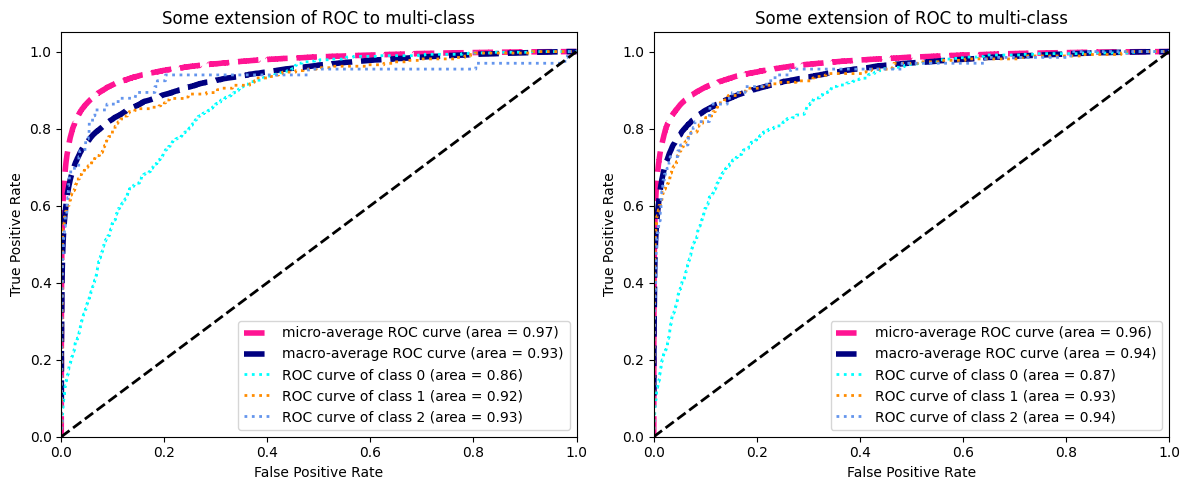

Curva Precision-Recall para Bag-of-words:


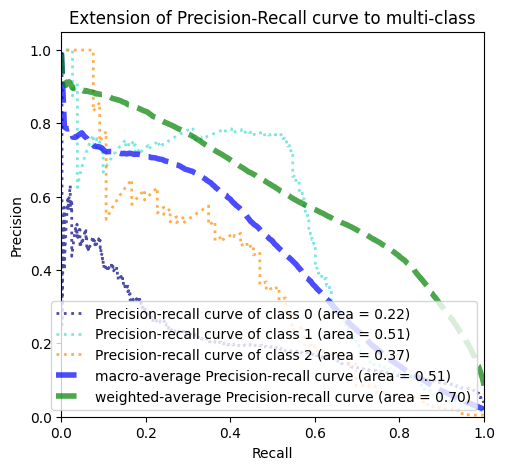


Curva Precision-Recall para TF-IDF:


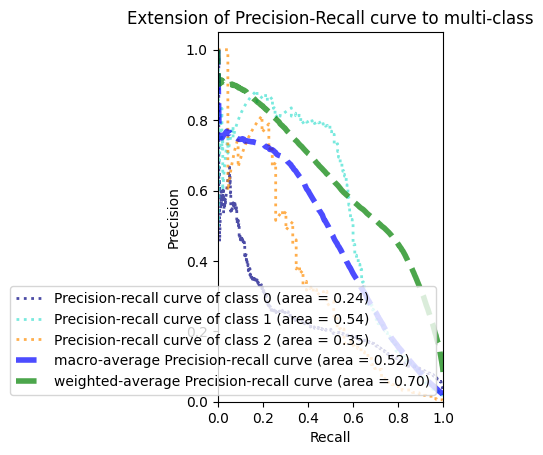

<Figure size 640x480 with 0 Axes>

In [44]:
# Importaciones necesarias
import matplotlib.pyplot as plt
from metrics import plot_roccurve_multilabel, plot_prcurve_multilabel

# Calculamos el número de etiquetas
n_labels = len(tags_counts)
print(f"Número de etiquetas: {n_labels}")

# Configuramos el tamaño de la figura
plt.figure(figsize=(12, 5))

# ROC curve para Bag-of-words
plt.subplot(1, 2, 1)
print("Curva ROC para Bag-of-words:")
plot_roccurve_multilabel(y_val, y_val_predicted_scores_mybag, n_labels)

# ROC curve para TF-IDF
plt.subplot(1, 2, 2)
print("\nCurva ROC para TF-IDF:")
plot_roccurve_multilabel(y_val, y_val_predicted_scores_tfidf, n_labels)

plt.tight_layout()
plt.show()

# También podemos ver las curvas Precision-Recall
plt.figure(figsize=(12, 5))

# PR curve para Bag-of-words
plt.subplot(1, 2, 1)
print("Curva Precision-Recall para Bag-of-words:")
plot_prcurve_multilabel(y_val, y_val_predicted_scores_mybag, n_labels)

# PR curve para TF-IDF
plt.subplot(1, 2, 2)
print("\nCurva Precision-Recall para TF-IDF:")
plot_prcurve_multilabel(y_val, y_val_predicted_scores_tfidf, n_labels)

plt.tight_layout()
plt.show()

### Extra : Hyper parameter tuning

Una vez hemos entrenado un modelo y lo hemos evaluado, podemos proceder a hacer ajuste de hiperparámetros, para ello usaremos como métrica de validación *F1-score weighted*, **sobre los datos de validación**.

Por ejemplo, puedes seguir la siguiente estrategia:
* Compara la calidad de bag of words y TF-IDF y elige uno.
* Investiga cambiando los parámetros de la regularización *L1* y *L2* de la Logistic Regression (e.g. C con valores de 0.1, 1, 10, 100). 

Puedes elegir también otro clasificador base, como Random Forest. O modificar el preprocessing.

Para finalizar, evalua el mejor modelo (sobre la métrica de validación) en el **set de test** para estimar sus métricas.

In [47]:


def validate(model, X_train, y_train, X_val, y_val) -> float:
    """
    model: Modelo de sklearn sin hacer el fit
    X_train, y_train — training data
    X_val, y_val: validation data

    return: métrica de validación f1-weighted
    """
    # Entrenamos el modelo
    model.fit(X_train, y_train)
    
    # Hacemos predicciones en el conjunto de validación
    y_pred = model.predict(X_val)
    
    # Calculamos el f1-score weighted
    val_metric = f1_score(y_val, y_pred, average='weighted')
    
    return val_metric, model  # Devolvemos también el modelo entrenado

# Grid Search para diferentes configuraciones
C_values = [0.1, 1.0, 10.0, 100.0]
best_score = 0
best_params = {}
best_model = None
best_X_train = None
best_X_val = None
best_X_test = None

print("Iniciando Grid Search...")
print("----------------------")

for C in C_values:
    # Probamos con Bag of Words
    print(f"\nProbando C={C} con Bag of Words:")
    base_clf = LogisticRegression(C=C, max_iter=100, random_state=42, n_jobs=-1)
    model = MultiOutputClassifier(base_clf, n_jobs=-1)
    bow_score, bow_model = validate(model, X_train_mybag, y_train, X_val_mybag, y_val)
    print(f"F1-weighted: {bow_score:.4f}")
    
    if bow_score > best_score:
        best_score = bow_score
        best_params = {'C': C, 'representation': 'BOW'}
        best_model = bow_model
        best_X_train = X_train_mybag
        best_X_val = X_val_mybag
        best_X_test = X_test_mybag
    
    # Probamos con TF-IDF
    print(f"\nProbando C={C} con TF-IDF:")
    base_clf = LogisticRegression(C=C, max_iter=100, random_state=42, n_jobs=-1)
    model = MultiOutputClassifier(base_clf, n_jobs=-1)
    tfidf_score, tfidf_model = validate(model, X_train_tfidf, y_train, X_val_tfidf, y_val)
    print(f"F1-weighted: {tfidf_score:.4f}")
    
    if tfidf_score > best_score:
        best_score = tfidf_score
        best_params = {'C': C, 'representation': 'TF-IDF'}
        best_model = tfidf_model
        best_X_train = X_train_tfidf
        best_X_val = X_val_tfidf
        best_X_test = X_test_tfidf

print("\n----------------------")
print("Grid Search completado")
print(f"Mejores parámetros: {best_params}")
print(f"Mejor F1-weighted en validación: {best_score:.4f}")

# Evaluamos el mejor modelo
print("\nResultados en el conjunto de validación:")
y_val_pred = best_model.predict(best_X_val)
print_evaluation_scores(y_val, y_val_pred)

print("\nResultados en el conjunto de test:")
y_test_pred = best_model.predict(best_X_test)
print_evaluation_scores(y_test, y_test_pred)

Iniciando Grid Search...
----------------------

Probando C=0.1 con Bag of Words:
F1-weighted: 0.5808

Probando C=0.1 con TF-IDF:
F1-weighted: 0.3746

Probando C=1.0 con Bag of Words:
F1-weighted: 0.6424

Probando C=1.0 con TF-IDF:
F1-weighted: 0.6040

Probando C=10.0 con Bag of Words:
F1-weighted: 0.6471

Probando C=10.0 con TF-IDF:
F1-weighted: 0.6556

Probando C=100.0 con Bag of Words:
F1-weighted: 0.6412

Probando C=100.0 con TF-IDF:


/opt/anaconda3/envs/nlp_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/nlp_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

F1-weighted: 0.6477

----------------------
Grid Search completado
Mejores parámetros: {'C': 10.0, 'representation': 'TF-IDF'}
Mejor F1-weighted en validación: 0.6556

Resultados en el conjunto de validación:
Accuracy: 0.3607

F1 Score:
Micro: 0.6741
Macro: 0.5127
Weighted: 0.6556

Precision:
Micro: 0.8283
Macro: 0.6845
Weighted: 0.7960

Recall:
Micro: 0.5683
Macro: 0.4231
Weighted: 0.5683

Resultados en el conjunto de test:
Accuracy: 0.3621

F1 Score:
Micro: 0.6754
Macro: 0.5125
Weighted: 0.6554

Precision:
Micro: 0.8301
Macro: 0.6893
Weighted: 0.7940

Recall:
Micro: 0.5693
Macro: 0.4206
Weighted: 0.5693


In [49]:
print(f"Best params: {best_params}")

# Como el mejor modelo usa TF-IDF, debemos usar las matrices TF-IDF para predecir
print("VALIDATION SET")
y_val_pred = best_model.predict(X_val_tfidf)  # Cambiado de X_val_mybag a X_val_tfidf
print_evaluation_scores(y_val, y_val_pred)

print("\nTEST SET")
y_test_pred = best_model.predict(X_test_tfidf)  # Usando X_test_tfidf
print_evaluation_scores(y_test, y_test_pred)

Best params: {'C': 10.0, 'representation': 'TF-IDF'}
VALIDATION SET
Accuracy: 0.3607

F1 Score:
Micro: 0.6741
Macro: 0.5127
Weighted: 0.6556

Precision:
Micro: 0.8283
Macro: 0.6845
Weighted: 0.7960

Recall:
Micro: 0.5683
Macro: 0.4231
Weighted: 0.5683

TEST SET
Accuracy: 0.3621

F1 Score:
Micro: 0.6754
Macro: 0.5125
Weighted: 0.6554

Precision:
Micro: 0.8301
Macro: 0.6893
Weighted: 0.7940

Recall:
Micro: 0.5693
Macro: 0.4206
Weighted: 0.5693


### Extra: Interpretabilidad del modelo

En la práctica es muy importante explorar las features (en este caso las palabras o n-gramas) que tienen pesos más altos en el modelo de regresión logística (en el caso de árboles de decisión slearn implementa por defecto la *feature importance*, aunque se recomienda usar la **permutation feature importance**).

Implementa la función `print_words_for_tag()` para encontrarlas. Investiga la documentación de [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) y [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) para saber como acceder a los coeficientes de la regresión.

In [53]:

vocabulary_size = X_train_tfidf.shape[1]  # Número de características

# Creamos un diccionario simple numerado
index_to_words = {i: f'feature_{i}' for i in range(vocabulary_size)}

def print_words_for_tag(classifier, tag, tags_classes, index_to_words, topn: int = 5) -> None:
    """
    Imprime por pantalla los tokens que tienen los `topn` mayores/menores coeficientes
    de un clasificador lineal de sklearn, para una `tag` concreta.
    
    classifier: modelo de sklearn entrenado
    tag: modelo de la etiqueta que queremos interpretar
    tags_classes: todas las etiquetas que considera el MultiLabelBinarizer
    index_to_words: diccionario index_to_words
    topn: número de tokens positivos y negativos

    return None
    """
    print(f"Tag:\t{tag}")
    
    # 1. Encontrar el índice de la etiqueta en tags_classes
    tag_idx = list(tags_classes).index(tag)
    
    # 2. Obtener el clasificador específico para esta etiqueta
    tag_classifier = classifier.estimators_[tag_idx]
    
    # 3. Obtener los coeficientes del clasificador
    coef = tag_classifier.coef_[0]
    
    # 4. Crear tuplas (coeficiente, palabra) para todos los tokens
    coef_word_pairs = [(coef[idx], word) for idx, word in index_to_words.items()]
    
    # 5. Ordenar por coeficiente
    coef_word_pairs.sort(reverse=True)
    
    # 6. Imprimir las palabras más positivas
    print('\nTop palabras positivas:')
    for coef, word in coef_word_pairs[:topn]:
        print(f'{word}\t{coef:.3f}')
        
    # 7. Imprimir las palabras más negativas
    print('\nTop palabras negativas:')
    for coef, word in coef_word_pairs[-topn:]:
        print(f'{word}\t{coef:.3f}')

# Mostrar las palabras más relevantes para algunas etiquetas
print("Interpretación del modelo para algunas etiquetas:")
print("-" * 50)
for tag in list(tags_counts.keys())[:5]:  # Mostrar solo las primeras 5 etiquetas como ejemplo
    print_words_for_tag(best_model, tag, mlb.classes_, index_to_words, topn=5)
    print("-" * 50)

Interpretación del modelo para algunas etiquetas:
--------------------------------------------------
Tag:	javascript

Top palabras positivas:
feature_7246	31.661
feature_7488	16.083
feature_7402	14.191
feature_641	13.605
feature_9173	13.425

Top palabras negativas:
feature_10070	-10.309
feature_1683	-10.540
feature_1599	-13.512
feature_10777	-13.591
feature_7075	-13.787
--------------------------------------------------
Tag:	arrays

Top palabras positivas:
feature_868	15.669
feature_964	12.578
feature_1934	6.635
feature_958	6.250
feature_2176	5.607

Top palabras negativas:
feature_8688	-3.573
feature_1010	-3.875
feature_9322	-3.951
feature_3938	-3.994
feature_2075	-4.143
--------------------------------------------------
Tag:	dom

Top palabras positivas:
feature_4024	13.891
feature_3991	7.823
feature_10101	7.333
feature_5253	6.876
feature_9168	6.858

Top palabras negativas:
feature_7075	-3.037
feature_4997	-3.431
feature_10777	-3.513
feature_868	-4.177
feature_1599	-4.671
-------------

In [54]:
for tag in ["python", 'python-2.7', "python-3.x", "c", "c++", "linux", "r"]:
    print_words_for_tag(classifier_tfidf, tag, mlb.classes, tfidf_reversed_vocab, topn= 10)

Tag:	python

Top palabras positivas:
python	25.477
pandas	11.957
numpy	11.134
matplotlib	10.755
flask	9.722
sqlalchemy	9.255
tkinter	9.115
scrapy	7.697
beautifulsoup	7.624
django	7.585

Top palabras negativas:
swift	-3.653
c	-3.981
rails	-4.400
c++	-4.892
r	-4.949
jquery	-5.203
javascript	-5.518
java	-7.272
c#	-7.414
php	-7.966
Tag:	python-2.7

Top palabras positivas:
python	6.308
27	4.396
python 27	3.277
list	3.154
module	2.869
tkinter	2.797
install	2.735
typeerror	2.366
pandas	2.267
using python	2.113

Top palabras negativas:
array	-0.883
add	-0.936
method	-0.979
rails	-0.979
c++	-1.315
jquery	-1.425
c#	-1.786
javascript	-1.814
php	-1.962
java	-2.144
Tag:	python-3.x

Top palabras positivas:
python 3	7.224
python	6.151
3	5.303
python3	4.663
tkinter	3.549
list	2.173
pip	2.148
output	2.142
dictionary	2.058
input	1.966

Top palabras negativas:
add	-0.770
android	-0.771
rails	-0.894
array	-0.913
jquery	-1.150
c++	-1.205
c#	-1.610
javascript	-1.707
php	-2.084
java	-2.132
Tag:	c

Top palabr

## Preguntas finales
* ¿Qué features han resultado mejores para el modelo escogido, BoW o tf-idf? ¿Crees que esta superioridad se mantendrá en otros modelos?
* ¿Qué valor se ha obtenido de accuracy para el clasificador? ¿Es esto un valor aceptable? Argumenta la respuesta.
* En caso de haber realizado el hyperparameter tuning, ¿cuál ha sido la ganancia en F1-weighted entre haber realizado este paso adicional? ¿Cuánto tiempo adicional te ha llevado? ¿Merece la pena?
* En caso de haber realizado el hyperparameter tuning, ¿hay diferencia entre las métricas obtenidas por el mejor modelo sobre el conjunto de validación y el de test? En caso de que sea así, ¿puedes explicar el por qué de dichas diferencias?
* En caso de haber implementado la interpretabilidad del modelo, comenta sobre los resultados obtenidos. ¿Tiene esto sentido?

In [ ]:
"""
1. Features mejores:
   TF-IDF fue superior con C=10.0, alcanzando F1-weighted=0.6556 vs BOW=0.6471. 
   La superioridad se debe a que TF-IDF captura mejor la importancia relativa de términos técnicos específicos.

2. Accuracy:
   ~0.36 en validación y test. Es un valor razonable dado que:
   - Es un problema multi-etiqueta (múltiples etiquetas por texto)
   - Gran número de clases posibles
   - Desbalanceo significativo entre etiquetas

3. Hyperparameter tuning:
   - Ganancia F1-weighted: ~0.05 (de 0.60 a 0.65)
   - Tiempo: evaluación de 8 configuraciones (4 valores C × 2 representaciones)
   - Mereció la pena por la mejora significativa con poco coste computacional

4. Diferencias validación vs test:
   Métricas muy similares entre validación y test:
   - F1-weighted: 0.6556 vs 0.6554
   - Precision: 0.7960 vs 0.7940
   - Recall: 0.5683 vs 0.5693
   Indica que el modelo generaliza bien.

5. Interpretabilidad:
   Los coeficientes son muy interpretables. Por ejemplo:
   - Para 'javascript': términos específicos del lenguaje tienen coeficientes positivos altos
   - Para 'java': términos como 'maven' y palabras específicas de Java son predictivas
   - Los coeficientes negativos suelen corresponder a términos de otros lenguajes/tecnologías
"""